# Modeling and Simulation of Parallel and Distributed Systems (MSPDS 2016)

In [1]:
## Matplotlib configuration
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.linear_model import RidgeCV, LinearRegression
from lib import DataFrameBuilder as df_builder
from lib import Humanizer, Plotter, Model
from mynotebook import *

## Wikipedia Application

### Target

,input size (GiB),workers,executions,outliers,available
0,45,4,30,0,30
1,45,8,30,3,27
2,45,16,30,1,29
3,45,32,30,0,30
4,45,64,30,7,23


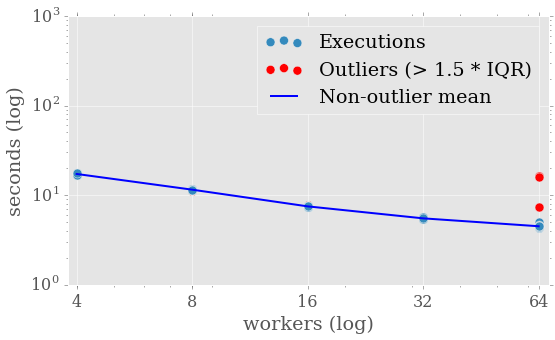

Total target application duration using the complete dataset (45 GB).


In [434]:
target = df_builder.get_target_df(stage=1)
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
plotter = Plotter((3.8, 68), (1, 1000), logx=True, logy=True)
caption = 'Total target application duration using the complete dataset (45 GB).'
target = remove_outliers(target, humanizer, plotter, caption)

### Profiling

#### Weak scaling

,input size (GiB),workers,executions,outliers,available
0,1,1,30,2,28
1,2,2,30,1,29
2,4,4,30,1,29
3,8,8,30,0,30
4,16,16,30,2,28
5,32,32,30,0,30
6,45,45,30,2,28


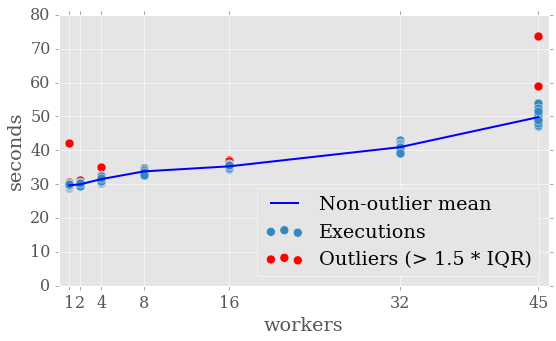

Total duration of the weak-scaling profiling experiment using the same amount of data (GB) as the amount of workers.


In [16]:
profiling = df_builder.get_weak_scaling_df()
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
plotter = Plotter((0, 46), loc='lower right')
caption = 'Total duration of the weak-scaling profiling experiment using the same' \
          ' amount of data (GB) as the amount of workers.'
profiling_ws = remove_outliers(profiling, humanizer, plotter, caption)

####  Strong scaling 1

,input size (GiB),workers,executions,outliers,available
0,1,1,10,0,10
1,1,2,10,0,10
2,1,4,10,0,10


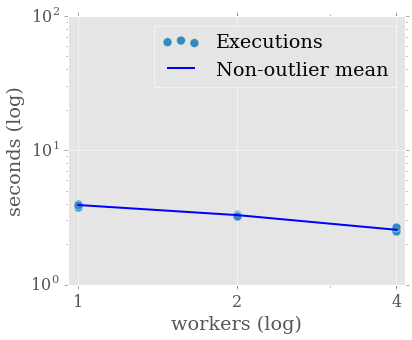

Total duration of profiling executions with 1-GB input using 1, 2 and 4 workers.


In [435]:
profiling = df_builder.get_strong_scaling_df(1, stage=1)
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
plotter = Plotter((0.956, 4.16), (1, 100), figsize=(6, 5), logx=True, logy=True)
caption = 'Total duration of profiling executions with 1-GB input using 1, 2 and 4 workers.'
profiling_ss1 = remove_outliers(profiling, humanizer, plotter, caption)

#### One VM

,input size (MiB),workers,executions,outliers,available
0,128,1,10,0,10
1,256,1,10,0,10
2,512,1,10,0,10
3,1024,1,10,0,10


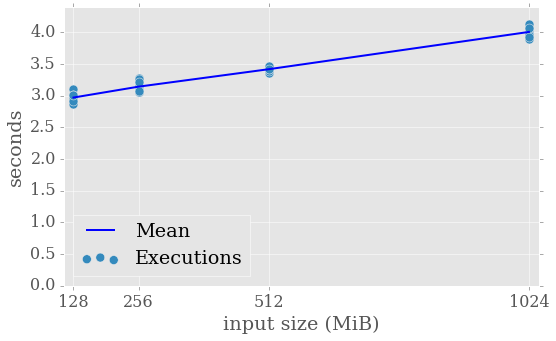

Total duration in one VM with different input sizes.


In [436]:
profiling = df_builder.get_one_vm_df(stage=1)
humanizer = Humanizer(size=Humanizer.SIZE_MIB)
plotter = Plotter((109, 1044), loc='lower left')
caption = 'Total duration in one VM with different input sizes.'
profiling_1vm = remove_outliers(profiling, humanizer, plotter, caption)

#### Strong scaling 2

,input size (GiB),workers,executions,outliers,available
0,1,1,10,1,9
1,1,2,10,2,8
2,1,3,10,1,9


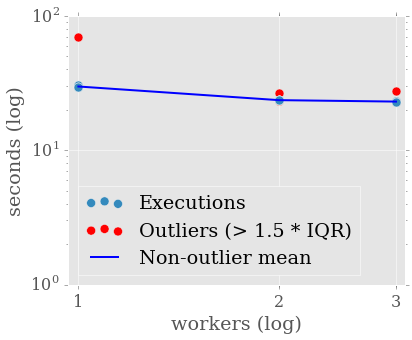

Total duration of profiling executions with 1-GB input using 1, 2 and 3 workers.


In [19]:
profiling = df_builder.get_strong_scaling_df(2)
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
plotter = Plotter((0.965, 3.1), (1, 100), figsize=(6, 5), logx=True, logy=True)
caption = 'Total duration of profiling executions with 1-GB input using 1, 2 and 3 workers.'
profiling_ss2 = remove_outliers(profiling, humanizer, plotter, caption)

### Machine Learning

#### Strong scaling 2

In [211]:
def add_features(df):
    threads = df['workers'] * 2
    tasks = np.ceil(df.input/(128 * 1024**2))
    df['first'] = np.ones(len(df)).astype('int')
    df['nonfirst'] = np.ceil((tasks - threads)/threads).astype('int')
    return df
prof_test = add_features(pd.concat([profiling_1vm, profiling_ss1]))
trgt_test = add_features(target.copy())

In [443]:
# 1 VM experiment
prof = profiling_1vm
trgt = target
model = Model(LinearRegression(), use_log=False)
model.fit(prof)
display(model.score(prof))
display(model.model.intercept_, model.model.coef_)
prediction_1vm = model.predict([[1, 48542876756]])
prediction_1vm

[0.015017604600536204,
 ((1, 134217465), 0.018393709328171793),
 ((1, 268425644), 0.020525900947076514),
 ((1, 536816741), 0.007382214386695593),
 ((1, 1073741798), 0.013768593740200924)]

2834.0789998785667

array([  0.00000000e+00,   1.09233171e-06])

array([ 55859.0026173])

In [444]:
# Strong-scale experiment
prof = profiling_ss1[profiling_ss1.workers < 3]
trgt = target
model = Model(LinearRegression(fit_intercept=True), use_log=False)
model.fit(prof)
display(model.score(prof))
linear = model.model
display(linear.intercept_, linear.coef_)

#linear.intercept_ += prediction_1vm - linear.predict([[1, 48542876756]])
linear.intercept_ = prediction_1vm - linear.coef_[0]
model.predict([[1, 48542876756]])

[0.012519456149516573,
 ((1, 1073741798), 0.013050807201866766),
 ((2, 1073741798), 0.011988105097166387)]

4531.1999999999998

array([-621.1,    0. ])

array([ 55859.0026173])

In [413]:
prof = pd.concat([profiling_1vm, profiling_ss1])
display(prof.sample(5, random_state=42))
trgt = target
model = Model(LinearRegression(), use_log=True)
#model = Model(RidgeCV(normalize=True, fit_intercept=True), use_log=True)
model.fit(prof)
#linear = model.model.named_steps['linear']
linear = model.model
display(linear.intercept_, linear.coef_)
display(model.score(prof))
display(model.score(trgt))

,ms,workers,input
22,3407,1,536816741
0,3109,1,134217465
9,3931,1,1073741798
4,3011,1,134217465
14,3313,2,1073741798


7.5433810843596465

array([-0.29841711,  0.14650549])

[0.025724716376760003,
 ((1, 134217465), 0.027172152131584925),
 ((1, 268425644), 0.02900246449734989),
 ((1, 536816741), 0.037740721947079524),
 ((1, 1073741798), 0.017222176662785686),
 ((2, 1073741798), 0.029382307396154828),
 ((4, 1073741798), 0.022331015339579437)]

[0.6276727544392462,
 ((4, 48542876756), 0.7361448668252615),
 ((8, 48542876756), 0.6787136967980056),
 ((16, 48542876756), 0.5985731785906493),
 ((32, 48542876756), 0.5555923136741818),
 ((64, 48542876756), 0.55697849823465)]

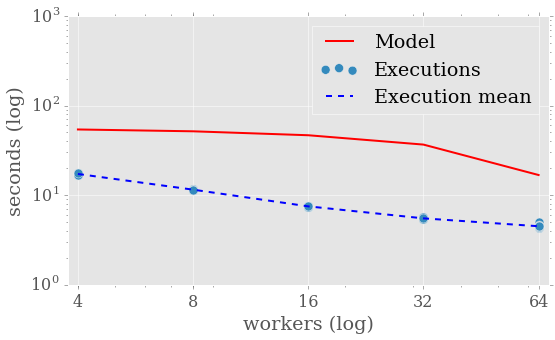

In [445]:
plotter = Plotter((3.77, 68), (1, 1000), logx=True, logy=True)
plotter.plot_model(model, trgt)

#### Weak Scaling

In [2]:
profiling = DataFrameBuilder.get_weak_scaling_df()
outlier = Outlier.is_outlier(profiling)
profiling = profiling[~outlier]
#profiling.columns = ['sec', 'workers', 'GiB']
#profiling.sec /= 1000
#profiling.GiB /= 1024**3

In [3]:
profiling.sample(3)

,ms,workers,input
124,41464,32,34359738259
64,29658,2,2147481045
8,30000,2,2147481045


In [3]:
target = DataFrameBuilder.get_target_df()
outlier = Outlier.is_outlier(target)
target = target[~outlier]
#target.columns = ['sec', 'workers', 'GiB']
#target.sec /= 1000
#target.GiB /= 1024**3

In [5]:
target.sample(3)

,ms,workers,input
122,45472,64,48542876756
10,184803,4,48542876756
116,44508,32,48542876756


In [29]:
profiling = display_experiment_overview1vm('data/wikipedia/profiling/one_vm/')

NameError: name 'display_experiment_overview1vm' is not defined

In [63]:
profiling.tail(3)

,input,ms,outlier
37,1073741798,29939,False
38,1073741798,30120,False
39,1073741798,29957,False


In [66]:
training = profiling[~profiling.outlier].drop('outlier', axis=1)
training.input /= 1024**2
training.tail(3)

,input,ms
37,1024.0,29939
38,1024.0,30120
39,1024.0,29957


,input,ms
24,536816741,23739
3,134217465,17986
16,268425644,20149


In [ ]:
from sklearn import linear_model

def eval_model(model, features, y, revert=None):
    display(features.sample(3))
    print('Training features')
    model.fit(features, y)
    
    # Predictions ordered by 1st col of 'features'
    to_predict = features.drop_duplicates().sort_values(features.columns[0])
    prediction = model.predict(to_predict)
    if revert:
        prediction = revert(prediction)

    # Plot total durations by number of workers.
    # From milliseconds to seconds
    df_plot = pd.DataFrame({'workers': dfp.workers, 'seconds': dfp.ms/1000})
    # Plot mean (non-outliers)
    means = df_plot.groupby('workers').mean().rename(columns={'seconds': 'Mean'})
    ax = means.plot(style='bo-', ms=8, figsize=(8, 5))
    # Plot predictions
    ax.plot([1, 2, 4], prediction/1000, 'rs--', label='Prediction', ms=8)

    # Plot settings
    ax.set_xticks(df.workers.unique())
    ax.set_xlim(0.9, 4.1)
    ax.set_ylim(0, None)
    ax.set_ylabel('seconds')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print('Mean durations from the experiment and model predictions.')
    
    return model


eval_model(linear_model.LinearRegression(), dfp[['workers', 'bytes']], dfp['ms'])

In [ ]:
# Using features' log

t_features = df[['workers', 'bytes']].apply(np.log2)
t_y = np.log2(df['ms'])
eval_model(linear_model.LinearRegression(), t_features, t_y, lambda x: 2**x)

In [ ]:
t_features = df[['workers', 'bytes']].apply(np.log2)

t_features['w2'] = t_features.workers**2
#t_features['b2'] = t_features.bytes**2
#t_features['wb'] = t_features.workers * t_features.bytes
t_y = np.log2(df['ms'])
eval_model(linear_model.LinearRegression(), t_features, t_y, lambda x: 2**x)

In [ ]:
t_features = pd.DataFrame()
t_features['workers'] = df.workers
t_features['GB'] = df.bytes/10**10
t_features['w2'] = t_features.workers**2
t_features['GB2'] = t_features.GB**2
t_features['wb'] = t_features.workers * t_features.GB
t_y = df['ms']
t_model = eval_model(linear_model.LinearRegression(), t_features, t_y)
print('{:f} {:s}'.format(t_model.intercept_, str(t_model.coef_)))

%reset_selective -f t_
%who_ls

#### Target Experiment

In [ ]:
t_experiment = Experiment()
apps = t_experiment.parse